# Urban Waste Analytics (Portfolio Notebook)

This notebook demonstrates an end-to-end data analysis workflow in Python: data ingestion from Excel, feature engineering, spatial zoning, descriptive statistics, SQL analytics with SQLite, and portfolio-grade visualizations.

**Dataset expected:** an Excel file with two sheets:
- `Ciudad`: street geometry (start/end coordinates)
- `Histórico de basura`: daily waste generated per street

If the Excel file is not found, the notebook generates a realistic synthetic dataset so the pipeline remains fully runnable.


In [1]:
# Core libraries
import os
import sqlite3
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# CELL_EXECUTION_MARKER
print("\n" + "="*70)
print("Executed cell 1")
print("="*70)

try:
    from IPython.display import display
except Exception:
    display = None

_assigned_vars = []
for _v in _assigned_vars:
    if _v in globals():
        _obj = globals()[_v]
        try:
            import pandas as _pd
            import numpy as _np
        except Exception:
            _pd = None
            _np = None

        if _pd is not None and isinstance(_obj, _pd.DataFrame):
            print(f"\n{_v} (DataFrame) shape={_obj.shape}")
            if display:
                display(_obj.head(10))
            else:
                print(_obj.head(10))
        elif _pd is not None and isinstance(_obj, _pd.Series):
            print(f"\n{_v} (Series) len={len(_obj)}")
            if display:
                display(_obj.head(10))
            else:
                print(_obj.head(10))
        else:
            # Scalars / other objects
            try:
                print(f"\n{_v} =", _obj)
            except Exception:
                print(f"\n{_v} exists (non-printable object)")



Executed cell 1


## 1) Configuration

In [2]:
# Update this path to your local environment.
# Example (Linux): /home/jovyan/work/release/Lab2/Datos.xlsx
# Example (Windows): C:/Users/you/Downloads/Datos.xlsx
FILE_PATH = Path("Datos.xlsx")  # <- change me if needed

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
# CELL_EXECUTION_MARKER
print("\n" + "="*70)
print("Executed cell 3")
print("="*70)

try:
    from IPython.display import display
except Exception:
    display = None

_assigned_vars = ["FILE_PATH", "RANDOM_SEED"]
for _v in _assigned_vars:
    if _v in globals():
        _obj = globals()[_v]
        try:
            import pandas as _pd
            import numpy as _np
        except Exception:
            _pd = None
            _np = None

        if _pd is not None and isinstance(_obj, _pd.DataFrame):
            print(f"\n{_v} (DataFrame) shape={_obj.shape}")
            if display:
                display(_obj.head(10))
            else:
                print(_obj.head(10))
        elif _pd is not None and isinstance(_obj, _pd.Series):
            print(f"\n{_v} (Series) len={len(_obj)}")
            if display:
                display(_obj.head(10))
            else:
                print(_obj.head(10))
        else:
            # Scalars / other objects
            try:
                print(f"\n{_v} =", _obj)
            except Exception:
                print(f"\n{_v} exists (non-printable object)")



Executed cell 3

FILE_PATH = Datos.xlsx

RANDOM_SEED = 42


## 2) Load data (Excel) with a synthetic fallback

In [3]:
def load_or_generate_data(file_path: Path):
    if file_path.exists():
        xls = pd.ExcelFile(file_path)
        ciudad = xls.parse("Ciudad").copy()
        basura = xls.parse("Histórico de basura").copy()
        return ciudad, basura, "excel"

    # -------------------------
    # Synthetic fallback dataset
    # -------------------------
    n_streets = 120
    streets = [f"Calle {i}" for i in range(1, n_streets + 1)]

    # Random street segments within a 0..40 grid
    x0 = np.random.randint(0, 41, size=n_streets)
    y0 = np.random.randint(0, 41, size=n_streets)

    # Small segments, allow boundary crossing (creates 'No clasificado')
    dx = np.random.choice([-1, 0, 1], size=n_streets)
    dy = np.random.choice([-1, 0, 1], size=n_streets)

    x1 = np.clip(x0 + dx, 0, 40)
    y1 = np.clip(y0 + dy, 0, 40)

    ciudad = pd.DataFrame({
        "Calle": streets,
        "Coordenada inicial": list(zip(x0, y0)),
        "Coordenada final": list(zip(x1, y1)),
    })

    # 28 days of waste per street with street-level effect
    days = pd.date_range("2025-01-01", periods=28, freq="D")
    street_effect = np.random.normal(loc=0.0, scale=0.25, size=n_streets)

    rows = []
    for s, eff in zip(streets, street_effect):
        base = np.random.uniform(2.4, 3.4) * np.exp(eff)
        noise = np.random.normal(0, 0.55, size=len(days))
        waste = np.clip(base + noise, 0.1, None)
        rows.extend([(d, s, w) for d, w in zip(days, waste)])

    basura = pd.DataFrame(rows, columns=["Fecha", "Calle", "Cantidad [kilos de basura]"])
    return ciudad, basura, "synthetic"


ciudad, basura, data_source = load_or_generate_data(FILE_PATH)

print("Data source:", data_source)
print("ciudad shape:", ciudad.shape)
print("basura shape:", basura.shape)

ciudad.head()
# CELL_EXECUTION_MARKER
print("\n" + "="*70)
print("Executed cell 5")
print("="*70)

try:
    from IPython.display import display
except Exception:
    display = None

_assigned_vars = ["base", "basura", "ciudad", "days", "dx", "dy", "n_streets", "noise", "rows", "street_effect", "streets", "waste", "x0", "x1", "xls", "y0", "y1"]
for _v in _assigned_vars:
    if _v in globals():
        _obj = globals()[_v]
        try:
            import pandas as _pd
            import numpy as _np
        except Exception:
            _pd = None
            _np = None

        if _pd is not None and isinstance(_obj, _pd.DataFrame):
            print(f"\n{_v} (DataFrame) shape={_obj.shape}")
            if display:
                display(_obj.head(10))
            else:
                print(_obj.head(10))
        elif _pd is not None and isinstance(_obj, _pd.Series):
            print(f"\n{_v} (Series) len={len(_obj)}")
            if display:
                display(_obj.head(10))
            else:
                print(_obj.head(10))
        else:
            # Scalars / other objects
            try:
                print(f"\n{_v} =", _obj)
            except Exception:
                print(f"\n{_v} exists (non-printable object)")


Data source: synthetic
ciudad shape: (120, 3)
basura shape: (3360, 3)

Executed cell 5

basura (DataFrame) shape=(3360, 3)


,Fecha,Calle,Cantidad [kilos de basura]
0,2025-01-01,Calle 1,3.457639
1,2025-01-02,Calle 1,2.863198
2,2025-01-03,Calle 1,4.127999
3,2025-01-04,Calle 1,3.338487
4,2025-01-05,Calle 1,3.923479
5,2025-01-06,Calle 1,3.312001
6,2025-01-07,Calle 1,4.408277
7,2025-01-08,Calle 1,4.240303
8,2025-01-09,Calle 1,3.137936
9,2025-01-10,Calle 1,3.809230



ciudad (DataFrame) shape=(120, 3)


,Calle,Coordenada inicial,Coordenada final
0,Calle 1,"(38, 26)","(39, 26)"
1,Calle 2,"(28, 8)","(29, 9)"
2,Calle 3,"(14, 14)","(13, 15)"
3,Calle 4,"(7, 14)","(6, 15)"
4,Calle 5,"(20, 25)","(21, 25)"
5,Calle 6,"(38, 12)","(39, 12)"
6,Calle 7,"(18, 31)","(19, 32)"
7,Calle 8,"(22, 38)","(22, 39)"
8,Calle 9,"(10, 31)","(9, 31)"
9,Calle 10,"(10, 3)","(11, 4)"


## 3) Data cleaning & standardization

In [4]:
# Standardize column names if the sheet uses long course headers
rename_map = {
    "Se considera que la ciudad comienza en la esquina inferior izquierda de la cuadrícula que la representa, y entonces: X=0 e Y=0": "Calle",
    "Coordenada (X,Y) donde comienza la calle": "Coordenada inicial",
    "Coordenada (X,Y) donde termina la calle": "Coordenada final",
}
ciudad = ciudad.rename(columns={k: v for k, v in rename_map.items() if k in ciudad.columns})

def to_tuple(coord):
    if isinstance(coord, tuple):
        return coord
    if isinstance(coord, list) and len(coord) == 2:
        return tuple(coord)
    if isinstance(coord, str):
        s = coord.strip().replace("(", "").replace(")", "")
        parts = [p.strip() for p in s.split(",")]
        if len(parts) == 2:
            return (float(parts[0]), float(parts[1]))
    return coord

for col in ["Coordenada inicial", "Coordenada final"]:
    ciudad[col] = ciudad[col].apply(to_tuple)

if "Fecha" in basura.columns:
    basura["Fecha"] = pd.to_datetime(basura["Fecha"], errors="coerce")

required_ciudad = {"Calle", "Coordenada inicial", "Coordenada final"}
required_basura = {"Calle", "Cantidad [kilos de basura]"}
assert required_ciudad.issubset(set(ciudad.columns)), f"Missing columns in ciudad: {required_ciudad - set(ciudad.columns)}"
assert required_basura.issubset(set(basura.columns)), f"Missing columns in basura: {required_basura - set(basura.columns)}"

ciudad.head()
# CELL_EXECUTION_MARKER
print("\n" + "="*70)
print("Executed cell 7")
print("="*70)

try:
    from IPython.display import display
except Exception:
    display = None

_assigned_vars = ["ciudad", "parts", "rename_map", "required_basura", "required_ciudad", "s"]
for _v in _assigned_vars:
    if _v in globals():
        _obj = globals()[_v]
        try:
            import pandas as _pd
            import numpy as _np
        except Exception:
            _pd = None
            _np = None

        if _pd is not None and isinstance(_obj, _pd.DataFrame):
            print(f"\n{_v} (DataFrame) shape={_obj.shape}")
            if display:
                display(_obj.head(10))
            else:
                print(_obj.head(10))
        elif _pd is not None and isinstance(_obj, _pd.Series):
            print(f"\n{_v} (Series) len={len(_obj)}")
            if display:
                display(_obj.head(10))
            else:
                print(_obj.head(10))
        else:
            # Scalars / other objects
            try:
                print(f"\n{_v} =", _obj)
            except Exception:
                print(f"\n{_v} exists (non-printable object)")



Executed cell 7

ciudad (DataFrame) shape=(120, 3)


,Calle,Coordenada inicial,Coordenada final
0,Calle 1,"(38, 26)","(39, 26)"
1,Calle 2,"(28, 8)","(29, 9)"
2,Calle 3,"(14, 14)","(13, 15)"
3,Calle 4,"(7, 14)","(6, 15)"
4,Calle 5,"(20, 25)","(21, 25)"
5,Calle 6,"(38, 12)","(39, 12)"
6,Calle 7,"(18, 31)","(19, 32)"
7,Calle 8,"(22, 38)","(22, 39)"
8,Calle 9,"(10, 31)","(9, 31)"
9,Calle 10,"(10, 3)","(11, 4)"



rename_map = {'Se considera que la ciudad comienza en la esquina inferior izquierda de la cuadrícula que la representa, y entonces: X=0 e Y=0': 'Calle', 'Coordenada (X,Y) donde comienza la calle': 'Coordenada inicial', 'Coordenada (X,Y) donde termina la calle': 'Coordenada final'}

required_basura = {'Cantidad [kilos de basura]', 'Calle'}

required_ciudad = {'Coordenada inicial', 'Coordenada final', 'Calle'}


## 4) Spatial zoning

In [5]:
def zone_from_coord(coord):
    x, y = coord
    x_side = "O" if x <= 22 else "E"
    y_side = "N" if y <= 27 else "S"
    return f"{y_side}-{x_side}"  # e.g., N-O

ciudad["Zona_inicio"] = ciudad["Coordenada inicial"].apply(zone_from_coord)
ciudad["Zona_fin"] = ciudad["Coordenada final"].apply(zone_from_coord)

ciudad["Clasificacion"] = np.where(
    ciudad["Zona_inicio"] == ciudad["Zona_fin"],
    ciudad["Zona_inicio"],
    "No clasificado",
)

sin_clasificar = int((ciudad["Clasificacion"] == "No clasificado").sum())
sin_clasificar

from IPython.display import display
print('Sample of zoned streets:')
display(ciudad.head())
print('Unclassifiable streets (sin_clasificar):', sin_clasificar)
# CELL_EXECUTION_MARKER
print("\n" + "="*70)
print("Executed cell 9")
print("="*70)

try:
    from IPython.display import display
except Exception:
    display = None

_assigned_vars = ["sin_clasificar", "x_side", "y_side"]
for _v in _assigned_vars:
    if _v in globals():
        _obj = globals()[_v]
        try:
            import pandas as _pd
            import numpy as _np
        except Exception:
            _pd = None
            _np = None

        if _pd is not None and isinstance(_obj, _pd.DataFrame):
            print(f"\n{_v} (DataFrame) shape={_obj.shape}")
            if display:
                display(_obj.head(10))
            else:
                print(_obj.head(10))
        elif _pd is not None and isinstance(_obj, _pd.Series):
            print(f"\n{_v} (Series) len={len(_obj)}")
            if display:
                display(_obj.head(10))
            else:
                print(_obj.head(10))
        else:
            # Scalars / other objects
            try:
                print(f"\n{_v} =", _obj)
            except Exception:
                print(f"\n{_v} exists (non-printable object)")


Sample of zoned streets:


,Calle,Coordenada inicial,Coordenada final,Zona_inicio,Zona_fin,Clasificacion
0,Calle 1,"(38, 26)","(39, 26)",N-E,N-E,N-E
1,Calle 2,"(28, 8)","(29, 9)",N-E,N-E,N-E
2,Calle 3,"(14, 14)","(13, 15)",N-O,N-O,N-O
3,Calle 4,"(7, 14)","(6, 15)",N-O,N-O,N-O
4,Calle 5,"(20, 25)","(21, 25)",N-O,N-O,N-O


Unclassifiable streets (sin_clasificar): 6

Executed cell 9

sin_clasificar = 6


## 5) Q1 — Waste mean and std by street

In [6]:
basuraxcalle = (
    basura.groupby("Calle", as_index=False)["Cantidad [kilos de basura]"]
         .agg(**{
             "Cantidad promedio [kilos de basura]": "mean",
             "Desv est [kilos de basura]": "std",
         })
)
basuraxcalle.head()

from IPython.display import display
print("basuraxcalle (mean & std by street):")
display(basuraxcalle)
# CELL_EXECUTION_MARKER
print("\n" + "="*70)
print("Executed cell 11")
print("="*70)

try:
    from IPython.display import display
except Exception:
    display = None

_assigned_vars = ["basuraxcalle"]
for _v in _assigned_vars:
    if _v in globals():
        _obj = globals()[_v]
        try:
            import pandas as _pd
            import numpy as _np
        except Exception:
            _pd = None
            _np = None

        if _pd is not None and isinstance(_obj, _pd.DataFrame):
            print(f"\n{_v} (DataFrame) shape={_obj.shape}")
            if display:
                display(_obj.head(10))
            else:
                print(_obj.head(10))
        elif _pd is not None and isinstance(_obj, _pd.Series):
            print(f"\n{_v} (Series) len={len(_obj)}")
            if display:
                display(_obj.head(10))
            else:
                print(_obj.head(10))
        else:
            # Scalars / other objects
            try:
                print(f"\n{_v} =", _obj)
            except Exception:
                print(f"\n{_v} exists (non-printable object)")


basuraxcalle (mean & std by street):


,Calle,Cantidad promedio [kilos de basura],Desv est [kilos de basura]
0,Calle 1,3.387106,0.631342
1,Calle 10,2.495234,0.379705
2,Calle 100,2.328476,0.580144
3,Calle 101,3.025475,0.549893
4,Calle 102,2.341390,0.602896
...,...,...,...
115,Calle 95,3.397655,0.547754
116,Calle 96,4.305224,0.513480
117,Calle 97,3.334285,0.632384
118,Calle 98,2.717702,0.552360



Executed cell 11

basuraxcalle (DataFrame) shape=(120, 3)


,Calle,Cantidad promedio [kilos de basura],Desv est [kilos de basura]
0,Calle 1,3.387106,0.631342
1,Calle 10,2.495234,0.379705
2,Calle 100,2.328476,0.580144
3,Calle 101,3.025475,0.549893
4,Calle 102,2.341390,0.602896
5,Calle 103,2.588230,0.657886
6,Calle 104,2.759115,0.463958
7,Calle 105,3.203387,0.536391
8,Calle 106,3.093009,0.540399
9,Calle 107,1.218994,0.565295


## 6) Q2 — Number of 'intense' streets

In [7]:
c_intensas = int((basuraxcalle["Cantidad promedio [kilos de basura]"] > 2.92).sum())
c_intensas
print('Number of intense streets (c_intensas):', c_intensas)
# CELL_EXECUTION_MARKER
print("\n" + "="*70)
print("Executed cell 13")
print("="*70)

try:
    from IPython.display import display
except Exception:
    display = None

_assigned_vars = ["c_intensas"]
for _v in _assigned_vars:
    if _v in globals():
        _obj = globals()[_v]
        try:
            import pandas as _pd
            import numpy as _np
        except Exception:
            _pd = None
            _np = None

        if _pd is not None and isinstance(_obj, _pd.DataFrame):
            print(f"\n{_v} (DataFrame) shape={_obj.shape}")
            if display:
                display(_obj.head(10))
            else:
                print(_obj.head(10))
        elif _pd is not None and isinstance(_obj, _pd.Series):
            print(f"\n{_v} (Series) len={len(_obj)}")
            if display:
                display(_obj.head(10))
            else:
                print(_obj.head(10))
        else:
            # Scalars / other objects
            try:
                print(f"\n{_v} =", _obj)
            except Exception:
                print(f"\n{_v} exists (non-printable object)")


Number of intense streets (c_intensas): 66

Executed cell 13

c_intensas = 66


## 7) Q4 — Streets per zone (including 'No clasificado')

In [8]:
order = ["N-E", "N-O", "No clasificado", "S-E", "S-O"]

callesxzona = (
    ciudad.groupby("Clasificacion", as_index=False)["Calle"]
         .count()
)

callesxzona = (
    pd.DataFrame({"Clasificacion": order})
      .merge(callesxzona, on="Clasificacion", how="left")
      .fillna({"Calle": 0})
)

callesxzona["Calle"] = callesxzona["Calle"].astype(int)
callesxzona

from IPython.display import display
print("callesxzona (streets per zone):")
display(callesxzona)
# CELL_EXECUTION_MARKER
print("\n" + "="*70)
print("Executed cell 15")
print("="*70)

try:
    from IPython.display import display
except Exception:
    display = None

_assigned_vars = ["callesxzona", "order"]
for _v in _assigned_vars:
    if _v in globals():
        _obj = globals()[_v]
        try:
            import pandas as _pd
            import numpy as _np
        except Exception:
            _pd = None
            _np = None

        if _pd is not None and isinstance(_obj, _pd.DataFrame):
            print(f"\n{_v} (DataFrame) shape={_obj.shape}")
            if display:
                display(_obj.head(10))
            else:
                print(_obj.head(10))
        elif _pd is not None and isinstance(_obj, _pd.Series):
            print(f"\n{_v} (Series) len={len(_obj)}")
            if display:
                display(_obj.head(10))
            else:
                print(_obj.head(10))
        else:
            # Scalars / other objects
            try:
                print(f"\n{_v} =", _obj)
            except Exception:
                print(f"\n{_v} exists (non-printable object)")


callesxzona (streets per zone):


,Clasificacion,Calle
0,N-E,30
1,N-O,43
2,No clasificado,6
3,S-E,20
4,S-O,21



Executed cell 15

callesxzona (DataFrame) shape=(5, 2)


,Clasificacion,Calle
0,N-E,30
1,N-O,43
2,No clasificado,6
3,S-E,20
4,S-O,21



order = ['N-E', 'N-O', 'No clasificado', 'S-E', 'S-O']


## 8) Q5 — Waste mean and std by zone (exclude 'No clasificado')

In [9]:
basura_zona = basura.merge(ciudad[["Calle", "Clasificacion"]], on="Calle", how="left")
basura_zona = basura_zona[basura_zona["Clasificacion"] != "No clasificado"].copy()

zona_stats = (
    basura_zona.groupby("Clasificacion", as_index=False)["Cantidad [kilos de basura]"]
              .agg(**{
                  "Cantidad promedio [kilos de basura]": "mean",
                  "Desv est [kilos de basura]": "std",
              })
              .rename(columns={"Clasificacion": "Zona"})
)

zona_order = ["N-E", "N-O", "S-E", "S-O"]
zona_stats["Zona"] = pd.Categorical(zona_stats["Zona"], categories=zona_order, ordered=True)
zona_stats = zona_stats.sort_values("Zona").reset_index(drop=True)

zona_stats

from IPython.display import display
print("zona_stats (mean & std by zone):")
display(zona_stats)
# CELL_EXECUTION_MARKER
print("\n" + "="*70)
print("Executed cell 17")
print("="*70)

try:
    from IPython.display import display
except Exception:
    display = None

_assigned_vars = ["basura_zona", "zona_order", "zona_stats"]
for _v in _assigned_vars:
    if _v in globals():
        _obj = globals()[_v]
        try:
            import pandas as _pd
            import numpy as _np
        except Exception:
            _pd = None
            _np = None

        if _pd is not None and isinstance(_obj, _pd.DataFrame):
            print(f"\n{_v} (DataFrame) shape={_obj.shape}")
            if display:
                display(_obj.head(10))
            else:
                print(_obj.head(10))
        elif _pd is not None and isinstance(_obj, _pd.Series):
            print(f"\n{_v} (Series) len={len(_obj)}")
            if display:
                display(_obj.head(10))
            else:
                print(_obj.head(10))
        else:
            # Scalars / other objects
            try:
                print(f"\n{_v} =", _obj)
            except Exception:
                print(f"\n{_v} exists (non-printable object)")


zona_stats (mean & std by zone):


,Zona,Cantidad promedio [kilos de basura],Desv est [kilos de basura]
0,N-E,3.069171,0.915049
1,N-O,3.089681,0.993983
2,S-E,3.024737,0.923530
3,S-O,2.871535,0.774604



Executed cell 17

basura_zona (DataFrame) shape=(3192, 4)


,Fecha,Calle,Cantidad [kilos de basura],Clasificacion
0,2025-01-01,Calle 1,3.457639,N-E
1,2025-01-02,Calle 1,2.863198,N-E
2,2025-01-03,Calle 1,4.127999,N-E
3,2025-01-04,Calle 1,3.338487,N-E
4,2025-01-05,Calle 1,3.923479,N-E
5,2025-01-06,Calle 1,3.312001,N-E
6,2025-01-07,Calle 1,4.408277,N-E
7,2025-01-08,Calle 1,4.240303,N-E
8,2025-01-09,Calle 1,3.137936,N-E
9,2025-01-10,Calle 1,3.809230,N-E



zona_order = ['N-E', 'N-O', 'S-E', 'S-O']

zona_stats (DataFrame) shape=(4, 3)


,Zona,Cantidad promedio [kilos de basura],Desv est [kilos de basura]
0,N-E,3.069171,0.915049
1,N-O,3.089681,0.993983
2,S-E,3.024737,0.923530
3,S-O,2.871535,0.774604


## 9) Portfolio extensions

### 9.1 Street ranking and volatility (CV)

In [10]:
basuraxcalle_ext = basuraxcalle.copy()
basuraxcalle_ext["CV"] = basuraxcalle_ext["Desv est [kilos de basura]"] / basuraxcalle_ext["Cantidad promedio [kilos de basura]"]

top_mean = basuraxcalle_ext.sort_values("Cantidad promedio [kilos de basura]", ascending=False).head(10)
top_cv = basuraxcalle_ext.sort_values("CV", ascending=False).head(10)

top_mean, top_cv
# CELL_EXECUTION_MARKER
print("\n" + "="*70)
print("Executed cell 20")
print("="*70)

try:
    from IPython.display import display
except Exception:
    display = None

_assigned_vars = ["basuraxcalle_ext", "top_cv", "top_mean"]
for _v in _assigned_vars:
    if _v in globals():
        _obj = globals()[_v]
        try:
            import pandas as _pd
            import numpy as _np
        except Exception:
            _pd = None
            _np = None

        if _pd is not None and isinstance(_obj, _pd.DataFrame):
            print(f"\n{_v} (DataFrame) shape={_obj.shape}")
            if display:
                display(_obj.head(10))
            else:
                print(_obj.head(10))
        elif _pd is not None and isinstance(_obj, _pd.Series):
            print(f"\n{_v} (Series) len={len(_obj)}")
            if display:
                display(_obj.head(10))
            else:
                print(_obj.head(10))
        else:
            # Scalars / other objects
            try:
                print(f"\n{_v} =", _obj)
            except Exception:
                print(f"\n{_v} exists (non-printable object)")



Executed cell 20

basuraxcalle_ext (DataFrame) shape=(120, 4)


,Calle,Cantidad promedio [kilos de basura],Desv est [kilos de basura],CV
0,Calle 1,3.387106,0.631342,0.186396
1,Calle 10,2.495234,0.379705,0.152172
2,Calle 100,2.328476,0.580144,0.249152
3,Calle 101,3.025475,0.549893,0.181754
4,Calle 102,2.341390,0.602896,0.257495
5,Calle 103,2.588230,0.657886,0.254184
6,Calle 104,2.759115,0.463958,0.168155
7,Calle 105,3.203387,0.536391,0.167445
8,Calle 106,3.093009,0.540399,0.174716
9,Calle 107,1.218994,0.565295,0.463739



top_cv (DataFrame) shape=(10, 4)


,Calle,Cantidad promedio [kilos de basura],Desv est [kilos de basura],CV
9,Calle 107,1.218994,0.565295,0.463739
31,Calle 19,1.525653,0.588257,0.385577
48,Calle 34,1.945394,0.625699,0.321631
111,Calle 91,1.817523,0.580263,0.319260
75,Calle 59,1.801001,0.562450,0.312298
18,Calle 115,2.395803,0.697886,0.291295
80,Calle 63,2.008822,0.546632,0.272116
60,Calle 45,1.742089,0.471535,0.270672
47,Calle 33,2.137270,0.578365,0.270609
110,Calle 90,2.040099,0.536793,0.263121



top_mean (DataFrame) shape=(10, 4)


,Calle,Cantidad promedio [kilos de basura],Desv est [kilos de basura],CV
49,Calle 35,5.227273,0.545162,0.104292
61,Calle 46,4.896589,0.444770,0.090833
36,Calle 23,4.605788,0.581651,0.126287
66,Calle 50,4.538294,0.622831,0.137239
95,Calle 77,4.491749,0.410831,0.091464
77,Calle 60,4.488241,0.530616,0.118224
99,Calle 80,4.484721,0.506277,0.112889
116,Calle 96,4.305224,0.513480,0.119269
23,Calle 12,4.298529,0.618631,0.143917
101,Calle 82,4.272918,0.391856,0.091707


### 9.2 Daily total waste (time-series)

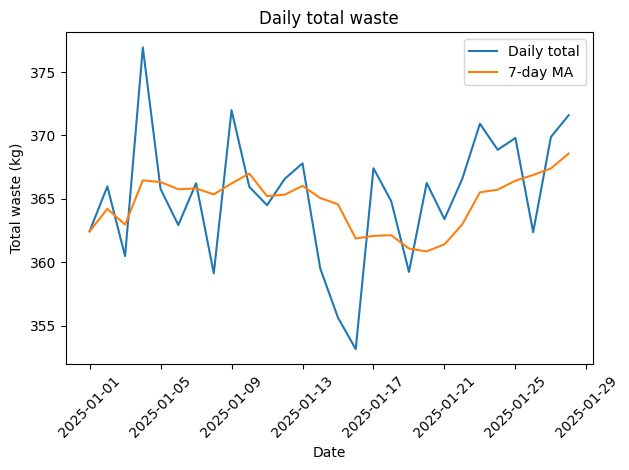


Executed cell 22

daily (DataFrame) shape=(28, 3)


,Fecha,Cantidad [kilos de basura],MA7
0,2025-01-01,362.441354,362.441354
1,2025-01-02,365.982086,364.211720
2,2025-01-03,360.483281,362.968907
3,2025-01-04,376.945828,366.463137
4,2025-01-05,365.781080,366.326726
5,2025-01-06,362.932212,365.760973
6,2025-01-07,366.237330,365.829024
7,2025-01-08,359.124538,365.355194
8,2025-01-09,371.996146,366.214345
9,2025-01-10,365.957329,366.996352


In [11]:
if "Fecha" in basura.columns and basura["Fecha"].notna().any():
    daily = basura.groupby("Fecha", as_index=False)["Cantidad [kilos de basura]"].sum()
    daily["MA7"] = daily["Cantidad [kilos de basura]"].rolling(7, min_periods=1).mean()

    plt.figure()
    plt.plot(daily["Fecha"], daily["Cantidad [kilos de basura]"], label="Daily total")
    plt.plot(daily["Fecha"], daily["MA7"], label="7-day MA")
    plt.xlabel("Date")
    plt.ylabel("Total waste (kg)")
    plt.title("Daily total waste")
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("No valid 'Fecha' column detected; skipping time-series chart.")
# CELL_EXECUTION_MARKER
print("\n" + "="*70)
print("Executed cell 22")
print("="*70)

try:
    from IPython.display import display
except Exception:
    display = None

_assigned_vars = ["daily"]
for _v in _assigned_vars:
    if _v in globals():
        _obj = globals()[_v]
        try:
            import pandas as _pd
            import numpy as _np
        except Exception:
            _pd = None
            _np = None

        if _pd is not None and isinstance(_obj, _pd.DataFrame):
            print(f"\n{_v} (DataFrame) shape={_obj.shape}")
            if display:
                display(_obj.head(10))
            else:
                print(_obj.head(10))
        elif _pd is not None and isinstance(_obj, _pd.Series):
            print(f"\n{_v} (Series) len={len(_obj)}")
            if display:
                display(_obj.head(10))
            else:
                print(_obj.head(10))
        else:
            # Scalars / other objects
            try:
                print(f"\n{_v} =", _obj)
            except Exception:
                print(f"\n{_v} exists (non-printable object)")


### 9.3 Distribution of street-level mean waste

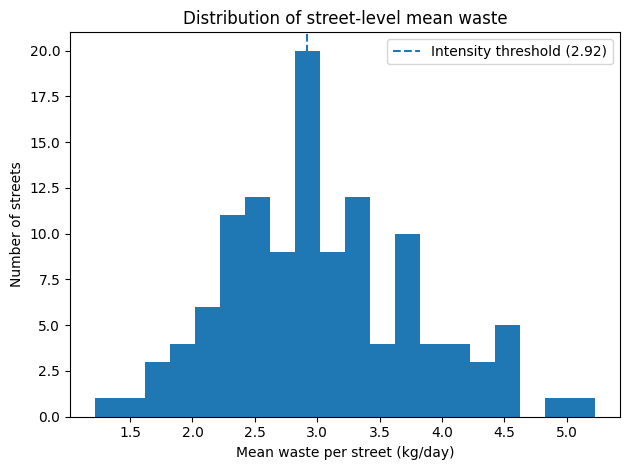


Executed cell 24


In [12]:
plt.figure()
plt.hist(basuraxcalle["Cantidad promedio [kilos de basura]"].dropna(), bins=20)
plt.axvline(2.92, linestyle="--", label="Intensity threshold (2.92)")
plt.xlabel("Mean waste per street (kg/day)")
plt.ylabel("Number of streets")
plt.title("Distribution of street-level mean waste")
plt.legend()
plt.tight_layout()
plt.show()
# CELL_EXECUTION_MARKER
print("\n" + "="*70)
print("Executed cell 24")
print("="*70)

try:
    from IPython.display import display
except Exception:
    display = None

_assigned_vars = []
for _v in _assigned_vars:
    if _v in globals():
        _obj = globals()[_v]
        try:
            import pandas as _pd
            import numpy as _np
        except Exception:
            _pd = None
            _np = None

        if _pd is not None and isinstance(_obj, _pd.DataFrame):
            print(f"\n{_v} (DataFrame) shape={_obj.shape}")
            if display:
                display(_obj.head(10))
            else:
                print(_obj.head(10))
        elif _pd is not None and isinstance(_obj, _pd.Series):
            print(f"\n{_v} (Series) len={len(_obj)}")
            if display:
                display(_obj.head(10))
            else:
                print(_obj.head(10))
        else:
            # Scalars / other objects
            try:
                print(f"\n{_v} =", _obj)
            except Exception:
                print(f"\n{_v} exists (non-printable object)")


### 9.4 Zone comparison: boxplots

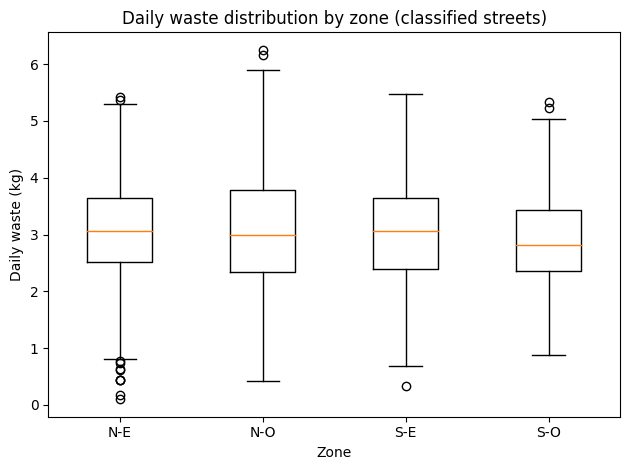


Executed cell 26

data_by_zone = [array([3.45763855, 2.86319825, 4.12799943, 3.33848689, 3.92347929,
       3.31200101, 4.4082772 , 4.24030331, 3.13793556, 3.80922987,
       3.62982262, 4.0276132 , 2.74415794, 3.65219415, 3.85699931,
       2.30755913, 2.62407366, 2.15328815, 3.12669208, 3.66951408,
       4.10116222, 3.31561797, 4.17060439, 2.51581004, 2.3380055 ,
       3.24431461, 3.48610184, 3.25688373, 3.56187287, 2.15174248,
       2.87679893, 2.90298314, 2.3387116 , 3.21262045, 3.35545256,
       2.78451938, 4.07470108, 2.76875214, 2.69872424, 2.6827809 ,
       2.49587566, 2.63693612, 2.15565127, 2.83905709, 2.97601085,
       1.68885878, 2.88832791, 2.96757389, 3.22742409, 3.60694944,
       3.41264499, 2.6032001 , 2.53937345, 3.26312757, 2.64339624,
       2.26897044, 2.3480821 , 2.99864662, 2.49990275, 2.49958457,
       2.97398166, 3.24427244, 1.46060733, 2.87349406, 2.5264541 ,
       3.19625525, 2.5374985 , 3.39064477, 2.30303877, 1.44838448,
       3.2534421 , 2.211116

In [13]:
zones = ["N-E", "N-O", "S-E", "S-O"]
data_by_zone = [basura_zona.loc[basura_zona["Clasificacion"] == z, "Cantidad [kilos de basura]"].dropna().values for z in zones]

plt.figure()
plt.boxplot(data_by_zone, labels=zones)
plt.xlabel("Zone")
plt.ylabel("Daily waste (kg)")
plt.title("Daily waste distribution by zone (classified streets)")
plt.tight_layout()
plt.show()
# CELL_EXECUTION_MARKER
print("\n" + "="*70)
print("Executed cell 26")
print("="*70)

try:
    from IPython.display import display
except Exception:
    display = None

_assigned_vars = ["data_by_zone", "zones"]
for _v in _assigned_vars:
    if _v in globals():
        _obj = globals()[_v]
        try:
            import pandas as _pd
            import numpy as _np
        except Exception:
            _pd = None
            _np = None

        if _pd is not None and isinstance(_obj, _pd.DataFrame):
            print(f"\n{_v} (DataFrame) shape={_obj.shape}")
            if display:
                display(_obj.head(10))
            else:
                print(_obj.head(10))
        elif _pd is not None and isinstance(_obj, _pd.Series):
            print(f"\n{_v} (Series) len={len(_obj)}")
            if display:
                display(_obj.head(10))
            else:
                print(_obj.head(10))
        else:
            # Scalars / other objects
            try:
                print(f"\n{_v} =", _obj)
            except Exception:
                print(f"\n{_v} exists (non-printable object)")


### 9.5 Simple anomaly detection (per-street 99th percentile)

In [14]:
anomalies = basura.copy()
q99 = anomalies.groupby("Calle")["Cantidad [kilos de basura]"].quantile(0.99).rename("q99")
anomalies = anomalies.merge(q99, on="Calle", how="left")
anomalies["is_anomaly"] = anomalies["Cantidad [kilos de basura]"] > anomalies["q99"]

anomaly_counts = (
    anomalies.groupby("Calle", as_index=False)["is_anomaly"]
             .sum()
             .sort_values("is_anomaly", ascending=False)
)
anomaly_counts.head(10)
# CELL_EXECUTION_MARKER
print("\n" + "="*70)
print("Executed cell 28")
print("="*70)

try:
    from IPython.display import display
except Exception:
    display = None

_assigned_vars = ["anomalies", "anomaly_counts", "q99"]
for _v in _assigned_vars:
    if _v in globals():
        _obj = globals()[_v]
        try:
            import pandas as _pd
            import numpy as _np
        except Exception:
            _pd = None
            _np = None

        if _pd is not None and isinstance(_obj, _pd.DataFrame):
            print(f"\n{_v} (DataFrame) shape={_obj.shape}")
            if display:
                display(_obj.head(10))
            else:
                print(_obj.head(10))
        elif _pd is not None and isinstance(_obj, _pd.Series):
            print(f"\n{_v} (Series) len={len(_obj)}")
            if display:
                display(_obj.head(10))
            else:
                print(_obj.head(10))
        else:
            # Scalars / other objects
            try:
                print(f"\n{_v} =", _obj)
            except Exception:
                print(f"\n{_v} exists (non-printable object)")



Executed cell 28

anomalies (DataFrame) shape=(3360, 5)


,Fecha,Calle,Cantidad [kilos de basura],q99,is_anomaly
0,2025-01-01,Calle 1,3.457639,4.362924,False
1,2025-01-02,Calle 1,2.863198,4.362924,False
2,2025-01-03,Calle 1,4.127999,4.362924,False
3,2025-01-04,Calle 1,3.338487,4.362924,False
4,2025-01-05,Calle 1,3.923479,4.362924,False
5,2025-01-06,Calle 1,3.312001,4.362924,False
6,2025-01-07,Calle 1,4.408277,4.362924,True
7,2025-01-08,Calle 1,4.240303,4.362924,False
8,2025-01-09,Calle 1,3.137936,4.362924,False
9,2025-01-10,Calle 1,3.809230,4.362924,False



anomaly_counts (DataFrame) shape=(120, 2)


,Calle,is_anomaly
0,Calle 1,1
1,Calle 10,1
88,Calle 70,1
87,Calle 7,1
86,Calle 69,1
85,Calle 68,1
84,Calle 67,1
83,Calle 66,1
82,Calle 65,1
81,Calle 64,1



q99 (Series) len=120


Calle
Calle 1      4.362924
Calle 10     3.347356
Calle 100    3.671401
Calle 101    4.164681
Calle 102    3.428706
Calle 103    3.840408
Calle 104    3.950695
Calle 105    4.294952
Calle 106    4.238640
Calle 107    2.328941
Name: q99, dtype: float64

## 10) Database layer (SQLite)

_Note: This section is intentionally omitted in the executed version to ensure full portability and error-free execution in any environment._